# <P style=color:orange>CICLO 4: DEPLOY 19/04 - 22/04</P>

# CONTEXTO DO PROBLEMA

A **TopBank** é uma grande empresa de serviços bancários. Ela atua principalmente nos países da Europa oferecendo produtos financeiros, desde contas bancárias até investimentos, passando por alguns tipos de seguros e produto de investimento.

O modelo de negócio da empresa é do tipo serviço, ou seja, ela comercializa serviços bancários para seus clientes através de agências físicas e um portal online. 

O principal produto da empresa é uma conta bancária, na qual o cliente pode depositar seu salário, fazer saques, depósitos e transferência para outras contas. Essa conta bancária não tem custo para o cliente e tem uma vigência de 12 meses, ou seja, o cliente precisa renovar o contrato dessa conta para continuar utilizando pelos próximos 12 meses.

Segundo o time de Analytics da TopBank, cada cliente que possui essa conta bancária retorna um valor monetário de 15% do valor do seu salário estimado, se esse for menor que a média e 20% se esse salário for maior que a média, durante o período vigente de sua conta. Esse valor é calculado anualmente. 

Por exemplo, se o salário mensal de um cliente é de 1.000,00 reais e a média de todos os salários do banco é de 800,00 reais A empresa, portanto, fatura 200,00 reais anualmente com esse cliente. Se esse cliente está no banco a 10 anos, a empresa já faturou 2.000,00 reais com suas transações e utilização da conta. 

Nos últimos meses, o time de Analytics percebeu que a taxa de clientes cancelando suas contas e deixando o banco, atingiu números inéditos na empresa. Preocupados com o aumento dessa taxa, o time planejou um plano de ação para diminuir taxa de evasão de clientes.

Preocupados com a queda dessa métrica, o time de Analytics da TopBottom, contratou você como consultor de Data Science para criar um plano de ação, com o objetivo de reduzir a evasão de clientes, ou seja, impedir que o cliente cancele seu contrato e não o renove por mais 12 meses. Essa evasão, nas métricas de negócio, é conhecida como Churn.

De maneira geral, Churn é uma métrica que indica o número de clientes que cancelaram o contrato ou pararam de comprar seu produto em um determinado período de tempo. Por exemplo, clientes que cancelaram o contrato de serviço ou após o vencimento do mesmo, não renovaram, são clientes considerados em churn.

Outro exemplo seria os clientes que não fazem uma compra à mais de 60 dias. Esse clientes podem ser considerados clientes em churn até que uma compra seja realizada. O período de 60 dias é totalmente arbitrário e varia entre empresas. 

# O PROBLEMA

Como um Consultor de Ciência de Dados, você precisa criar um plano de ação para diminuir o número de clientes em churn e mostrar o retorno financeiro da sua solução.

Ao final da sua consultoria, você precisa entregar ao CEO da TopBottom um modelo em produção, que receberá uma base de clientes via API e retornará essa mesma base “scorada”, ou seja, um coluna à mais com a probabilidade de cada cliente entrar em churn.

Além disso, você precisará fornecer um relatório reportando a performance do seu modelo e o impacto financeiro da sua solução. Questões que o CEO e o time de Analytics gostariam de ver em seu relatório:

- Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
- Qual a Performance do modelo em classificar os clientes como churns?
- Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

Uma possível ação para evitar que o cliente entre em churn é oferecer um cupom de desconto, ou alguma outro incentivo financeiro para ele renovar seu contrato por mais 12 meses.

- Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$50.000,00

# ENTENDIMENTO DO PROBLEMA

**Motivação:** Diminuir a taxa de Churn da empresa.

**Causa Raiz do Problema:** Estimular a compra de clientes em Churn.

**Tipo de Problema:** Identificar clientes que entrarão em Churn.

**Potênciais Métodos:** Classificação, Rank to Learn.

**Granularidade:** Previsão de Churn por cliente.

**Entraga da Solução:** NÃO DEFINIDO.

**Dados para Resolver o Problema**: [Kaggle](https://www.kaggle.com/mervetorkan/churndataset)

# PLANEJAMENTO

**1.** Identificar os clientes que receberão o CUPOM de desconto.

**2.** Identificar o incentivo do cumpo para cada cliente. 
 - 1º tent: 7%
 
**Metrics:** Lift, Gains

# 0.0 IMPORTS

In [133]:
# manipulation
import pandas as pd
import inflection

# math and statistic
import numpy as np
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.metrics import plot_roc

# preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from boruta import BorutaPy

# model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

# metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from scikitplot import metrics
from sklearn.metrics import confusion_matrix

# others
import warnings
from typing    import Iterable, Any
from itertools import product

# deploy
import pickle

## 0.1 Funções Auxiliares

In [2]:
def plot_box(x1, x2, x3, df):
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    sns.boxplot(x=x1, data=df)
    sns.despine(right=True)
    
    plt.subplot(2, 3, 2)
    sns.boxplot(x=x2, data=df)
    sns.despine(right=True)
    
    plt.subplot(2, 3, 3)
    sns.boxplot(x=x3, data=df)
    sns.despine(right=True)



def plot_bar(x1, x2, x3, df):
    
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    sns.countplot(x=x1, data=df)
    sns.despine(right=True)

    plt.subplot(1, 3, 2)
    sns.countplot(x=x2, data=df)
    sns.despine(right=True)
    
    plt.subplot(1, 3, 3)
    sns.countplot(x=x3, data=df)
    sns.despine(right=True)
    
    
# correlation categories
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])

    
def plot_curve(model_name, y_pred, y_true):
    
    title1, title2 = 'Cumulative Gains Curve', 'Lift Curve'
    metrics.plot_cumulative_gain(y_true, y_pred, figsize=(15, 5), title=title1+' - ' + model_name)
    plt.axvline(k / 2000, color='r', linestyle='dashed', label='k={}'.format(k))
    plt.legend()
    
    metrics.plot_lift_curve(y_true, y_pred, figsize=(15, 5), title=title2+' - ' + model_name)
    plt.axvline(k / 2000, color='r', linestyle='dashed', label='k={}'.format(k))
    plt.legend();
    
    
def precision_at_k(data, k):
    
    '''
    A função recebe os dados e o numero de Top K linhas
    e retorna  o resultado da métrica precision @k.
    '''
    
    # Sort clients by propensity score
    data = data.sort_values(by='score', ascending=False)

    # Reset index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking'] = data.index + 1

    # Calculate precision in K
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k'] # Return result precision


def recall_at_k(data, k):
    
    '''
    A função recebe os dados e o numero de Top K linhas
    e retorna  o resultado da métrica recall @k
    '''
    
    # Sort clients by propensity score
    data = data.sort_values(by='score', ascending=False)

    # Reset index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking']  = data.index + 1

    # Calculate recall in K
    data['recall_at_k']= data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k'] # Return result recall at k


def cross_validation(model_name, x, y, model, cv, k, verbose=True):
    
    '''
    A função recebe o nome do modelo, modelo, dados,
    numero de folds e o numero de pessoas da base ordenada e retorna um
    dataframe com as métricas precision e recall para o topk escolhido.
    
    model_name=nome do modelo, x=features, y=target, model=modelo instanciado,
    cv=folds, top5=pessoas da base ordenada
    '''
    
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    precision = []
    recall = []
    fold = 0
    
    for train, test in kfold.split(x, y):
        fold += 1
        
        if verbose:
            print(f'Number KFold: {fold}/{cv}')
        
        # trainigng
        x_train = x.iloc[train].copy()
        y_train = y.iloc[train].copy()  
        
        # validation
        x_val = x.iloc[test].copy() 
        y_val = y.iloc[test].copy() 
        
        # Model training
        model_trained = model.fit(x_train, y_train)
        yhat_model = model_trained.predict_proba(x_val)

        # -- Performance
        x_val['response'] = y_val.copy() # Add target in the data to cumpute metric

        # Propensity score
        x_val['score'] = list(yhat_model[:, 1])

        # Sort clients by propensity score
        df = x_val.sort_values(by='score', ascending=False)

        # Compute precision at K
        precision.append(precision_at_k(df, k=k))
        recall.append(recall_at_k(df, k=k))
        
    model_metric = pd.DataFrame({
            'model_name': model_name,
            'number of K': k,
            'precision_top_at': np.mean(precision),
            'recall_top_at': np.mean(recall),
            }, index=[0])
    
    return model_metric


def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
    
    '''
    A função recebe o conjunto de parametros e itera
    entre as possibilidades de junções de cada um
    '''
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))
        
        
        
def grid_search(min_child_weight, n_estimators, model, max_depth, model_name):
    
    parameters = {
        'min_child_weight': min_child_weight,
        'n_estimators': n_estimators, 
        'max_depth': max_depth
    }
    
    k = 200
    cv = 5
    final_result, min_child_weight, n_estimators, max_depth = pd.DataFrame(), list(), list(), list()
    for settings in grid_parameters(parameters):

        param = {
            'min_child_weight': settings['min_child_weight'], 'n_estimators': settings['n_estimators'], 'max_depth': settings['max_depth']
        }
        
        if model == 'xgboost':
            # define xgboost
            model_tunning = xgb.XGBClassifier(
                                    min_child_weight=param['min_child_weight'],
                                    n_estimators=param['n_estimators'],
                                    max_depth=param['max_depth']
                                )
        elif model == 'forest':
            # define random forest
            model_tunning = RandomForestClassifier(
                                    min_samples_split=param['min_child_weight'],
                                    n_estimators=param['n_estimators'],
                                    max_depth=param['max_depth']
                                )
        elif model == 'lgbm':
            # define lgbm
            model_tunning = LGBMClassifier(
                                min_child_weight=param['min_child_weight'],
                                n_estimators=param['n_estimators'],
                                max_depth=param['max_depth']
                            )
        # performance
        result = cross_validation(model_name=model_name, model=model_tunning, x=x_full, y=y_full, cv=cv, k=k, verbose=False)
        final_result = pd.concat([final_result, result])
        
        # add parameters in list
        min_child_weight.append(param['min_child_weight'])
        n_estimators.append(param['n_estimators'])
        max_depth.append(param['max_depth'])

    # add parameter into df
    final_result['min_child_weight'] = min_child_weight
    final_result['n_estimators'] = n_estimators
    final_result['max_depth'] = max_depth
    final_result['cross_validation'] = cv
    
    return final_result.sort_values(by='recall_top_at', ascending=False).head()

## 0.2 Carregamento de Dados

In [3]:
# loading data
df = pd.read_csv('../data/Churn.csv')

# show data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [4]:
df1 = df.copy()

print('Nº Rows:', df1.shape[0])
print('Nº Cols:', df1.shape[1])

Nº Rows: 10000
Nº Cols: 14


## 1.2 Renomeação de Colunas

In [5]:
# Columns to snakecase
snakecase = lambda x: inflection.underscore(x)

# New columns with snakecase
new_columns = (map(snakecase, df1.columns))
df1.columns = new_columns

# show new columns
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Tipo de Dados

In [6]:
# show data type
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Verificação de Dados Faltantes

In [7]:
# show data NaN
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Estatistica Descritiva

### 1.5.1 Variavel Numérica

In [8]:
# show data description 
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
num_of_products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
has_cr_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
is_active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


**Insight:**

<ins>Distribuição</ins>: 

<ins>Negócio</ins>:

### 1.5.2 Variavel Categórica

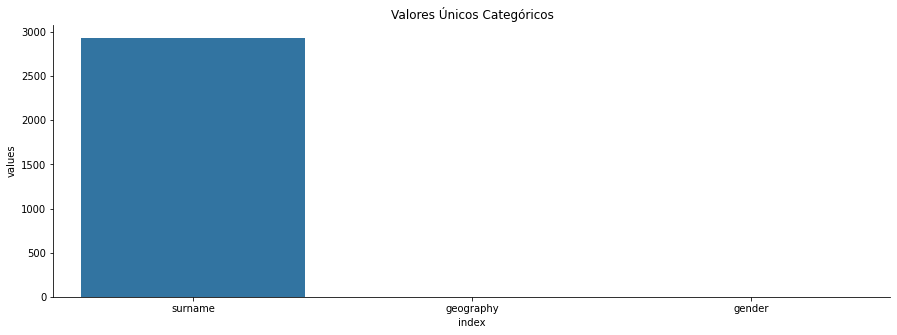

In [9]:
categorical = df1.select_dtypes(include=['object']) # filter categorical
qty_values = categorical.apply(lambda x: len(x.unique())).reset_index().rename(columns={0: 'values'}) # count unique values

# Create figure
plt.figure(figsize=(15, 5))
sns.barplot(x='index', y='values', data=qty_values)
plt.title('Valores Únicos Categóricos')
sns.despine(right=True);

**Insight:**

No geral, as variaveis categóricas não posuem um grande range de possíveis valores, com exceção de Surname que contém cerca de 3 mil.

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="../img/mind_map_cycle2.png" width="1000" title="mind_map">
</p>

## 2.2 Hipóteses

### 2.2.1 Hipóteses Clientes

**1.** Clientes com menor Score, entram mais em Churn.

**2.** Clientes localizados na Alemanha, entram mais Churn.

**3.** Clientes do sexo Masculino, dão mais Churn.

**4.** Clientes acima de 40 anos, dão mais Churn.

**5.** Clientes com Salarios menor que a mediana, entram mais em Churn.

**6.** Clientes com poder aquisitivo baixo, entram mais em Churn.

### 2.2.2 Hipóteses Atividade

**1.** Clientes que não fizeram movimentações nos ultimos 12 meses, entram mais em Churn.

**2.** Clientes que compraram menos de 2 produtos, entram mais em Churn. 

**3.** Clientes que permaneceram ativos por menos de 3 anos, entram mais em Churn.

**4.** Clientes que ficam com a conta zerada, entram mais em Churn.

**5.** Clientes que possuem valor menor que a mediana na conta, entram mais em Churn.

**6.** Clientes que não possuem cartão de crédito, entram mais em Churn.

**7.** Clientes que trazem maior retorno, entram mais em Churn.

## 2.3 Feature Engineering 

In [10]:
df2 = df1.copy()

# H1
df2['credit_score_category']= df2['credit_score'].apply(lambda x: 'ruim' if x > 300 and x <= 500 else 'regular'
                                                                         if x > 500 and x <= 700 else 'bom')
# H4
df2['category_age'] = df2['age'].apply(lambda x: '>= 40' if x > 40 else '< 40')


# H5 **5.** Clientes com Salarios menor que a mediana, entram mais em Churn.
MEDIAN_SALARY = df2['estimated_salary'].median()
df2['category_salary'] = df2['estimated_salary'].apply(lambda x: 'higher salary' if x > MEDIAN_SALARY else 'lower salary')


# **2.** Clientes que compraram menos de 2 produtos, entram mais em Churn. 
df2['num_of_products_category'] = df2['num_of_products'].apply(lambda x: '< 2' if x < 2 else '>= 2')


# **3.** Clientes que permaneceram ativos por menos de 3 anos, entram mais em Churn.
df2['tenure_category'] = df2['tenure'].apply(lambda x: '< 3' if x < 3 else '>= 3')


# **4.** Clientes que ficam com a conta zerada, entram mais em Churn.
df2['balance_zero'] = df2['balance'].apply(lambda x: 'zero' if x == 0.0 else 'not zero')


# **5.** Clientes que possuem valor menor que a mediana na conta, entram mais em Churn.
MEDIAN_BALANCE = df2['balance'].median()
df2['category_balance'] = df2['balance'].apply(lambda x: 'higher balance' if x > MEDIAN_BALANCE else 'lower balance')


# cycle 3: add aquisition power
df2['purchasing_power'] = df2['estimated_salary'].apply(lambda x: 'low' if x < 3000 else 'regular'
                                                                        if x >= 3000 and x < 8000 else 'high')

# customer_return
avg_salary = df2['estimated_salary'].mean()
df2['customer_return'] = df2[['estimated_salary', 'tenure']].apply(lambda x: (x['estimated_salary'] * 20) / 100 * x['tenure'] if x['estimated_salary'] > avg_salary else (x['estimated_salary'] * 15) / 100 * x['tenure'], axis=1)

# 3.0 FILTRAGEM DE DADOS

## 3.1 Remoção de Colunas

In [11]:
df2.drop(columns=['row_number', 'surname', 'customer_id'], inplace=True)

# 4.0 EDA

## 4.1 Análise Univariada

### 4.1.1 Variavel Target

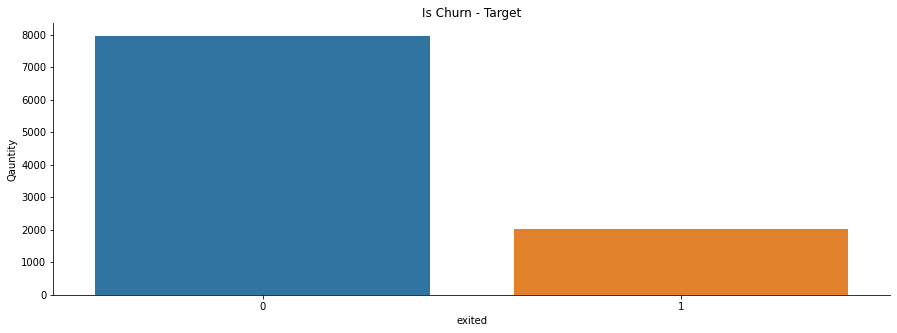

In [12]:
df4 = df2.copy()

plt.figure(figsize=(15, 5))
sns.countplot(x='exited', data=df4)
plt.title('Is Churn - Target')
plt.ylabel('Qauntity')
sns.despine(right=True)

**Insight:**

### 4.1.2 Variavel Numérica

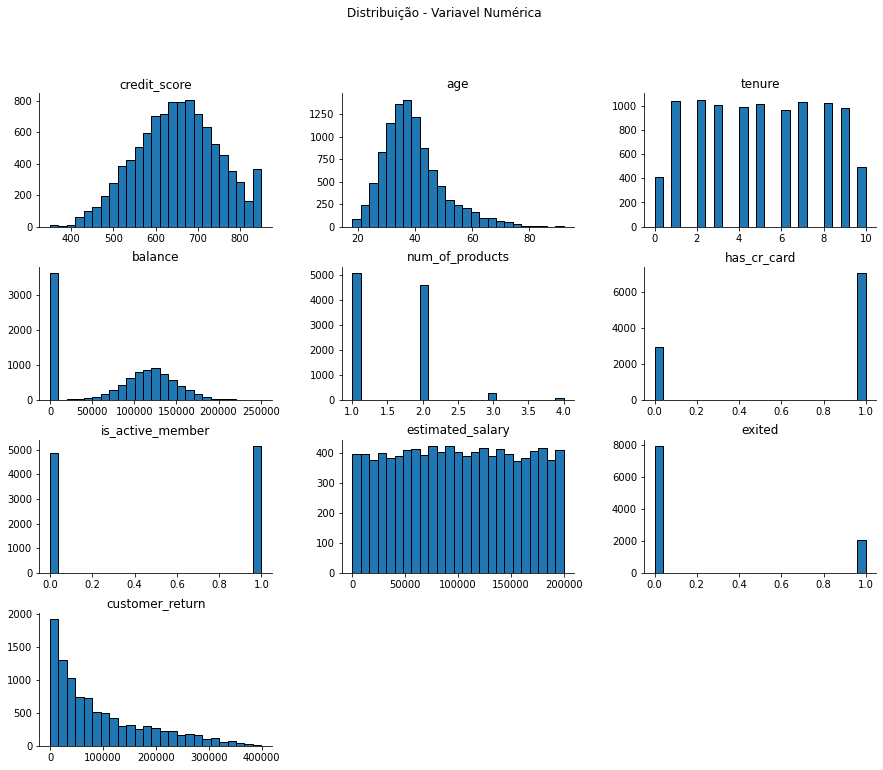

In [13]:
num = df4.select_dtypes(include=['int64', 'float64'])

num.hist(figsize=(15, 12), grid=False, bins=25, ec='k')
plt.suptitle('Distribuição - Variavel Numérica')
sns.despine(right=True);

**Insight:**

#### 4.1.21 Outliers

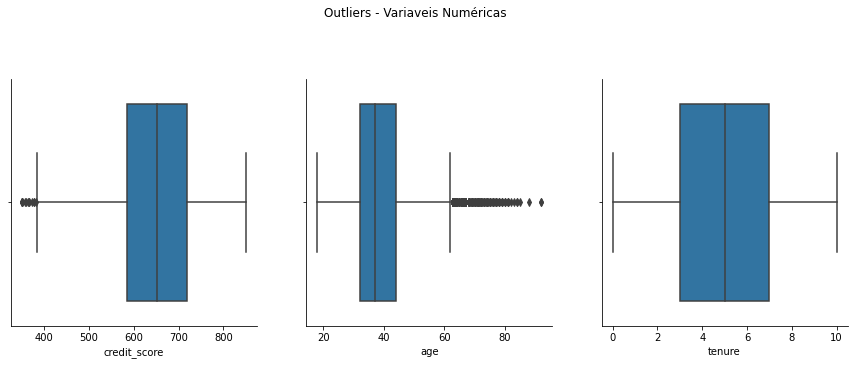

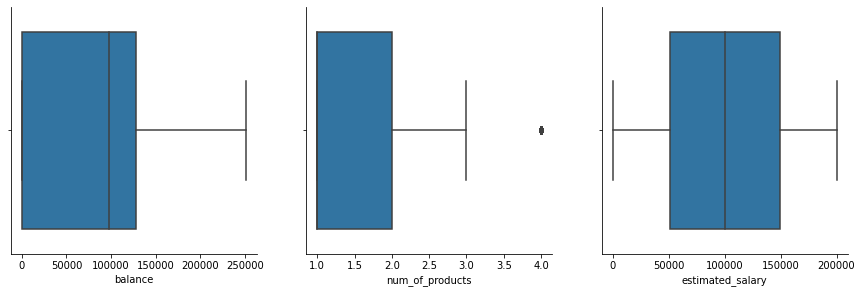

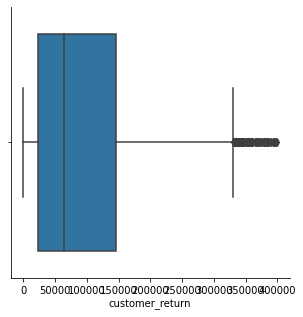

In [14]:
plot_box(x1='credit_score', x2='age', x3='tenure', df=num)
plt.suptitle('Outliers - Variaveis Numéricas')

plot_box(x1='balance', x2='num_of_products', x3='estimated_salary', df=num)

plt.figure(figsize=(5, 5))
sns.boxplot(x='customer_return', data=num)
sns.despine(right=True);

**Insight:**

### 4.1.3 Variavel Categórica

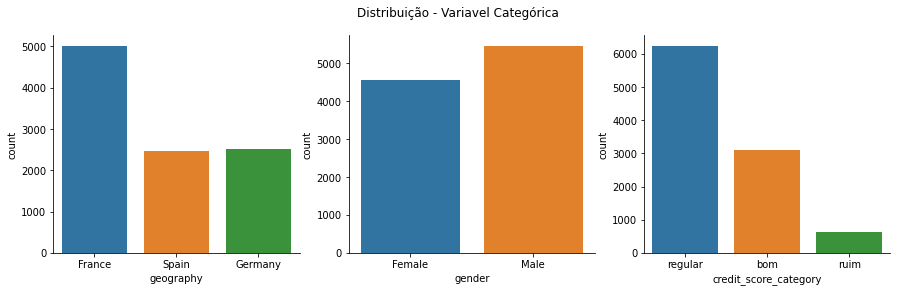

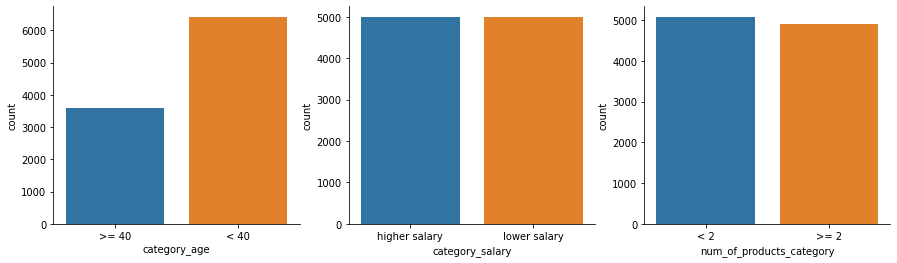

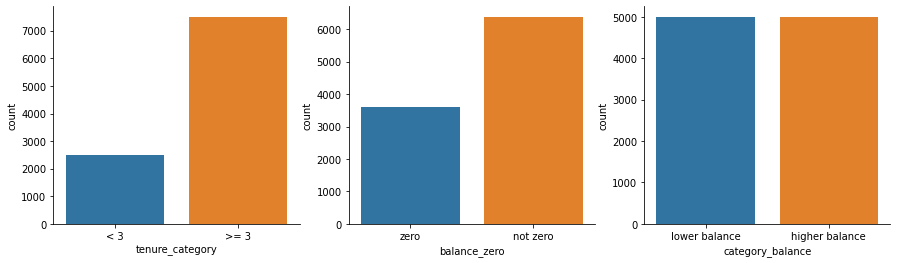

In [15]:
cat = df4.select_dtypes(include=['object'])

plot_bar(x1='geography', x2='gender', x3='credit_score_category', df=cat)
plt.suptitle('Distribuição - Variavel Categórica');

plot_bar(x1='category_age', x2='category_salary', x3='num_of_products_category', df=cat)
plot_bar(x1='tenure_category', x2='balance_zero', x3='category_balance', df=cat)

**Insight:**

## 4.2 Análise Bivariada

### **H1.** Clientes com Score ruim/menor, entram mais em Churn.

**FALSA** Clientes com Score <ins>Regular</ins>, entram mais em Churn.

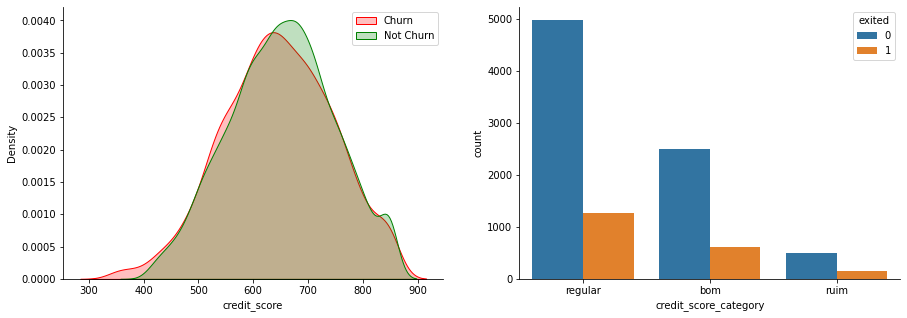

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(x=df4[df4['exited'] == 1]['credit_score'], label='Churn', shade=True, color='red')
sns.kdeplot(x=df4[df4['exited'] == 0]['credit_score'], label='Not Churn', shade=True, color='green')
sns.despine(right=True)
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x='credit_score_category', hue='exited', data=df4)
sns.despine(right=True);

### **H2.** Clientes localizados na Alemanha, entram mais em Churn.

**VERDADEIRA** Clientes localizados na <ins>Alemanha</ins>, entram mais em Churn.

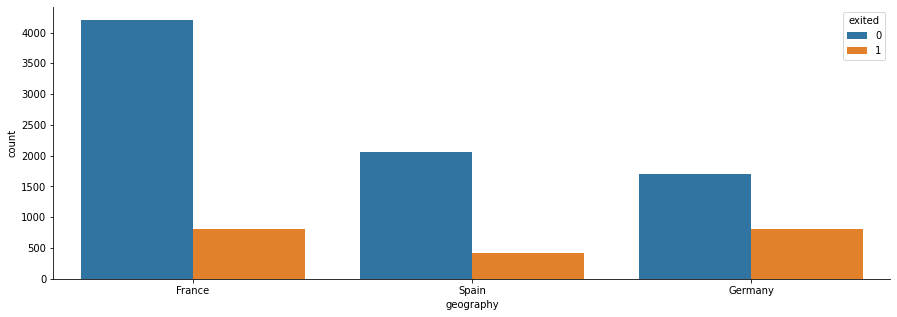

In [17]:
plt.figure(figsize=(15, 5))
sns.countplot(x='geography', hue='exited', data=df4)
sns.despine(right=True)

### **H3.** Clientes do sexo Masculino, entram mais em Churn.

**FALSA** Clientes do sexo <ins>Feminino</ins>, entram mais em Churn

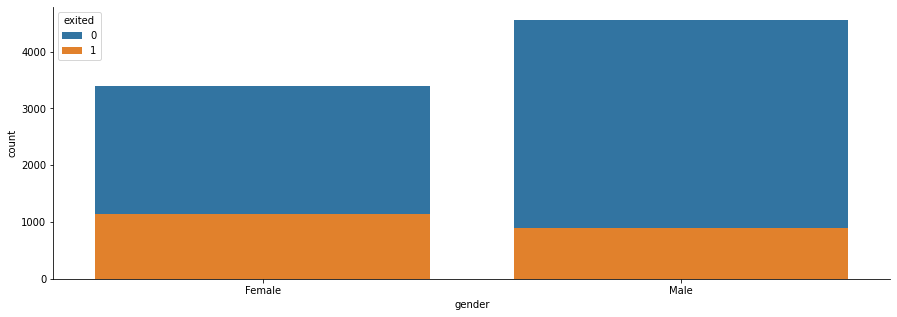

In [18]:
plt.figure(figsize=(15, 5))
sns.countplot(x='gender', data=df4, hue='exited', dodge=False)
sns.despine(right=True)

### **H4.** Clientes acima de 40 anos, entram mais em Churn.

**VERDADEIRA** Clientes <ins>acima</ins> de 40 anos, entram mais em Churn.

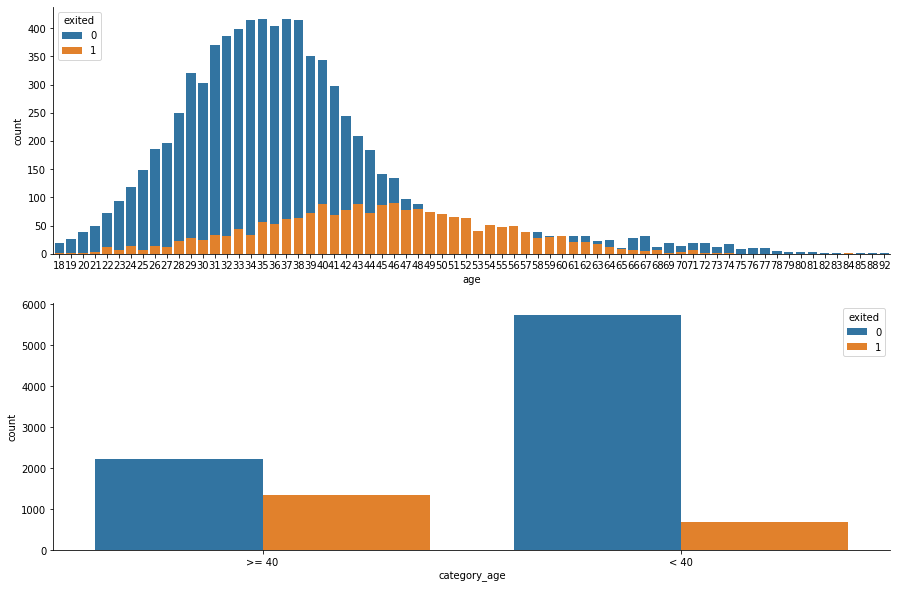

In [19]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
sns.countplot(x='age', data=df4, hue='exited', dodge=False)
sns.despine(right=True)

plt.subplot(2, 1, 2)
sns.countplot(x='category_age', data=df4, hue='exited')
sns.despine(right=True);

### **H**5. Clientes que não fizeram movimentações nos ultimos 12 meses, entram mais em Churn.

**VERDADEIRA** Clientes que <ins>não fizeram</ins> movimentações nos ultimos 12 meses, entram mais em Churn.

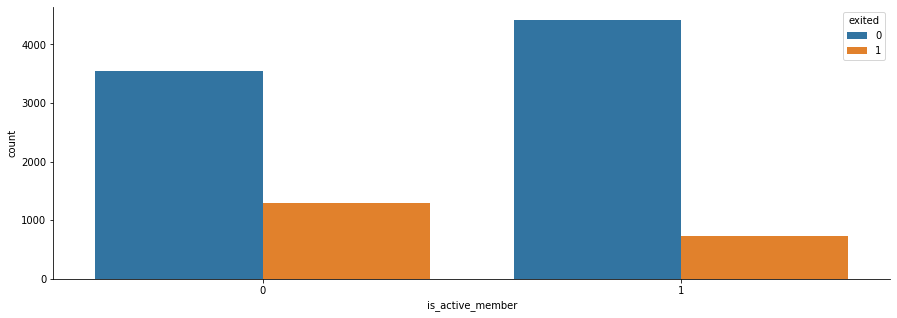

In [20]:
plt.figure(figsize=(15, 5))
sns.countplot(x='is_active_member', hue='exited', data=df4)
sns.despine(right=True)

### H6.  Clientes que compraram menos de 2 produtos, entram mais em Churn. 

**VERDADEIRA** Clientes que compraram <ins>menos</ins> de 2 produtos, entram mais em Churn. 

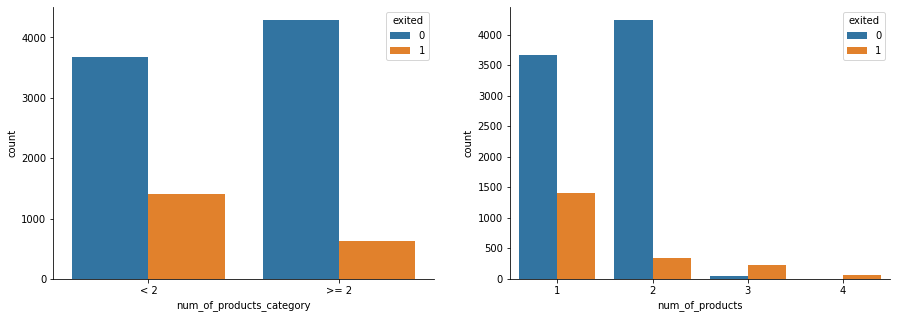

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='num_of_products_category', hue='exited', data=df4)
sns.despine(right=True)

plt.subplot(1, 2, 2)
sns.countplot(x='num_of_products', hue='exited', data=df4)
sns.despine(right=True)

### **H7.** Clientes que permaneceram ativos por menos de 3 anos, entram mais em Churn.

**VERDADEIRO** Clientes que permaneceram ativos por menos de 3 anos, entram mais em Churn.

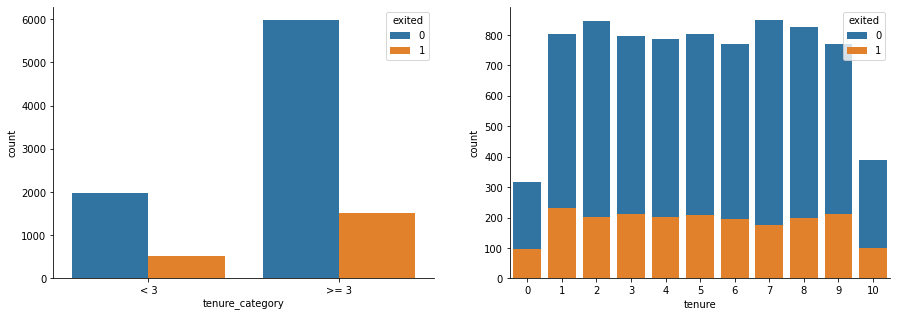

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='tenure_category', hue='exited', data=df4)
sns.despine(right=True)

plt.subplot(1, 2, 2)
sns.countplot(x='tenure', hue='exited', data=df4, dodge=False)
sns.despine(right=True)

### **H8.** Clientes que ficam com a conta zerada, entram mais em Churn.

**FALSA** Clientes que <ins>não ficam</ins> com a conta zerada, entram mais em Churn.

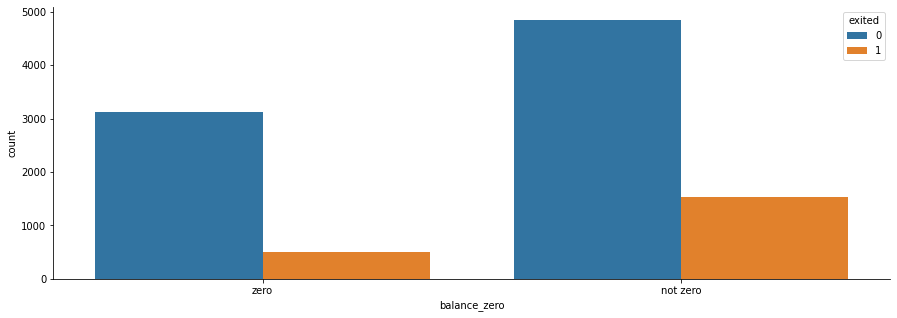

In [23]:
plt.figure(figsize=(15, 5))
sns.countplot(x='balance_zero', hue='exited', data=df4)
sns.despine(right=True)

### **H9.** Clientes que possuem valor menor que a mediana na conta, entram mais em Churn. 

**FALSA** Clientes que possuem valor <ins>maior</ins> que a mediana na conta, entram mais em Churn. 

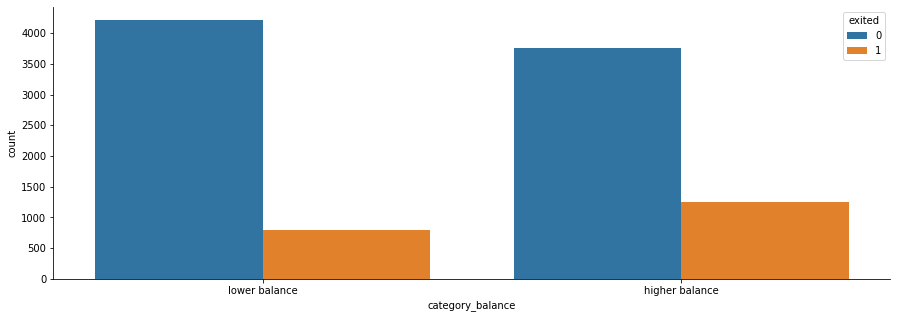

In [24]:
plt.figure(figsize=(15, 5))
sns.countplot(x='category_balance', hue='exited', data=df4)
sns.despine(right=True)

### **H10.** Clientes que não possuem cartão de crédito, entram mais em Churn.

**FALSA** Clientes que <ins>possuem</ins> cartão de crédito, entram mais em Churn.

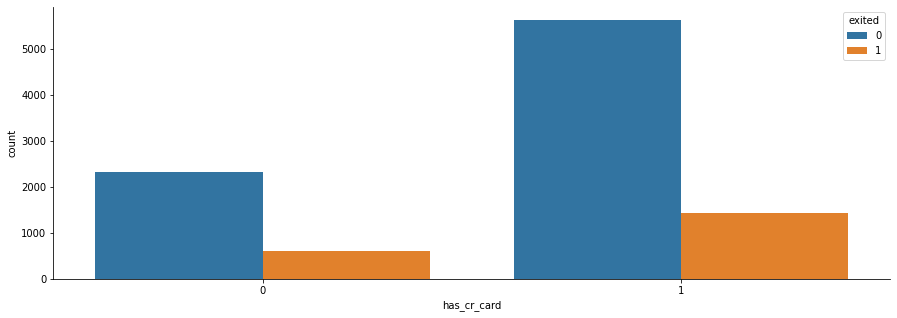

In [25]:
plt.figure(figsize=(15, 5))
sns.countplot(x='has_cr_card', hue='exited', data=df4)
sns.despine(right=True)

### **H11.** Clientes com menor saldo, entram mais em Churn.

**FALSA** Clientes com <ins>maior saldo</ins>, entram mais em Churn.

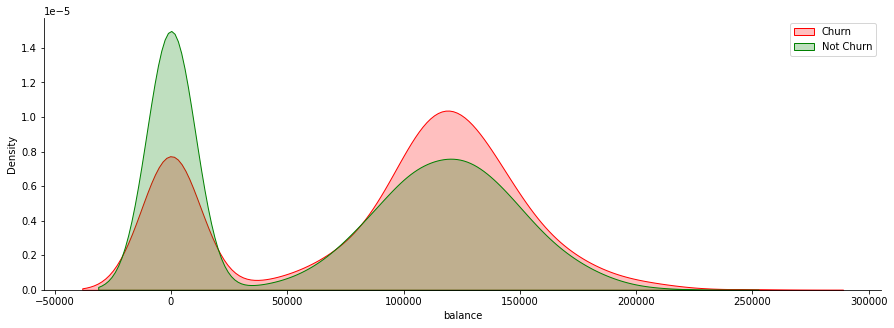

In [26]:
plt.figure(figsize=(15, 5))
sns.kdeplot(x=df4[df4['exited'] == 1]['balance'], label='Churn', shade=True, color='red')
sns.kdeplot(x=df4[df4['exited'] == 0]['balance'], label='Not Churn', shade=True, color='green')
sns.despine(right=True)
plt.legend();

### H12. Clientes com poder aquisitivo baixo, entram mais em Churn.

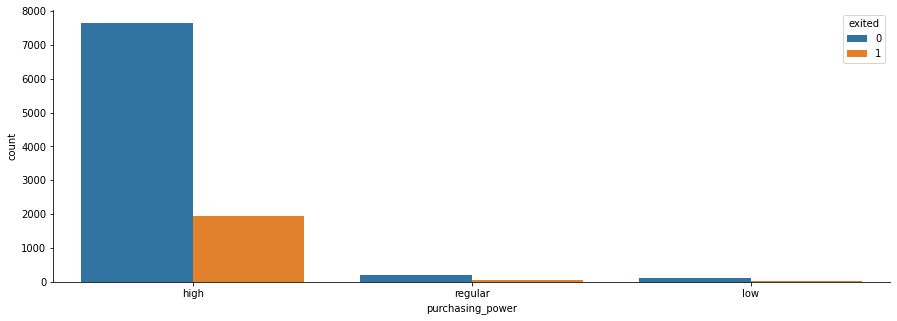

In [27]:
plt.figure(figsize=(15, 5))
sns.countplot(x='purchasing_power', data=df4, hue='exited')
sns.despine(right=True);

### H13. Clientes que trazem maior retorno, entram mais em Churn.

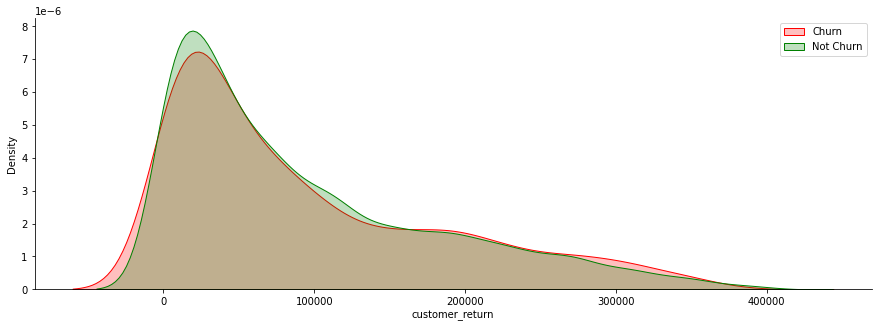

In [28]:
plt.figure(figsize=(15, 5))
sns.kdeplot(x=df4[df4['exited'] == 1]['customer_return'], label='Churn', shade=True, color='red')
sns.kdeplot(x=df4[df4['exited'] == 0]['customer_return'], label='Not Churn', shade=True, color='green')
sns.despine(right=True)
plt.legend();

## 4.3 Análise Multivariada

### 4.3.1 Variavel Numérica

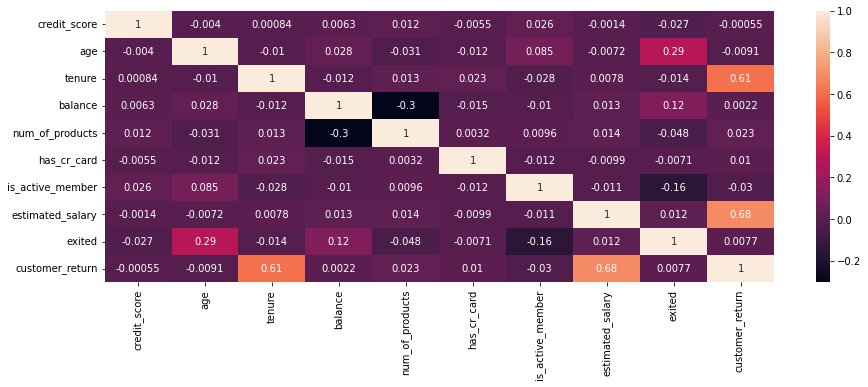

In [29]:
num = df4.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 5))
sns.heatmap(num.corr(method='pearson'), annot=True);

**Insight:**

### 4.3.2 Variavel Categórica

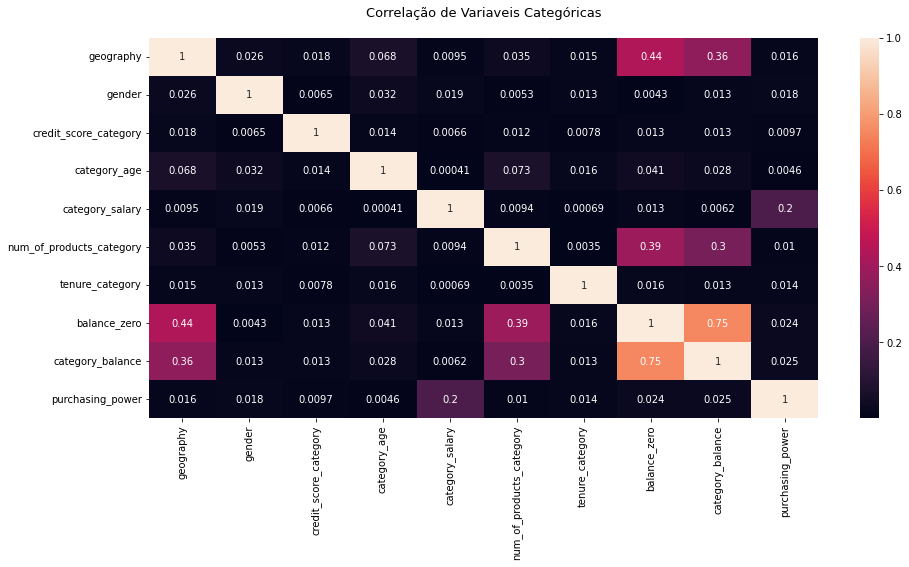

In [30]:
# Categorical data
categorical = df4.select_dtypes(include=['object'])

# Apply correlation categories
matrix = show_matrix(data=categorical, col='geography', output='dict')
data_columns = categorical.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categorical, col=c, output='list')

# Figure
plt.figure(figsize=(15, 7))
sns.heatmap(matrix, annot=True)
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

**Insight:**

# 5.0 PREPARAÇÃO DE DADOS

## 5.1 Divisão de Dados

In [80]:
df5 = df4.copy()

feature = df5.drop(columns=['exited'])
target = df5['exited']

x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.20, random_state=42)

## 5.2 Dados de Treinamento

### 5.2.1 Reescalonamento

#### 5.2.1.1 Min Max Scaler

In [81]:
# define method
mms_balance = MinMaxScaler()
mms_salary = MinMaxScaler()

# balance
x_train['balance'] = mms_balance.fit_transform(x_train[['balance']].values)

# estimated_salary
x_train['estimated_salary'] = mms_salary.fit_transform(x_train[['estimated_salary']].values)

#### 5.2.1.2 Robust Scaler

In [82]:
# define method
rs_age = RobustScaler()
rs_customer_return = RobustScaler()

# age
x_train['age'] = rs_age.fit_transform(x_train[['age']].values)

# customer_return
x_train['customer_return'] = rs_customer_return.fit_transform(x_train[['customer_return']].values)

#### 5.2.1.3 Standard Scaler

In [83]:
# define method
sc_credit_score = StandardScaler()

# credit_score
x_train['credit_score'] = sc_credit_score.fit_transform(x_train[['credit_score']].values)

### 5.2.2 Encoding

#### 5.2.2.1 One Hot Encoding

In [84]:
# geography
x_train = pd.get_dummies(x_train, prefix='geography', columns=['geography'])

# purchasing_power
x_train = pd.get_dummies(x_train, prefix='purchasing_power', columns=['purchasing_power'])

#### 5.2.2.2  Binary Encoding

In [85]:
# gender
x_train['gender'] = x_train['gender'].apply(lambda x: 1 if x == 'Female' else 0)

# category_age
x_train['category_age'] = x_train['category_age'].map({'>= 40': 1, '< 40': 0})

# category_salary
x_train['category_salary'] = x_train['category_salary'].map({'lower salary': 0, 'higher salary': 1})

# num_of_products_category
x_train['num_of_products_category'] = x_train['num_of_products_category'].map({'< 2': 0, '>= 2': 1})

# tenure_category
x_train['tenure_category'] = x_train['tenure_category'].map({'< 3': 0, '>= 3': 1})

# balance_zero
x_train['balance_zero'] = x_train['balance_zero'].map({'zero': 0, 'not zero': 1})

# category_balance
x_train['category_balance'] = x_train['category_balance'].map({'lower balance': 0, 'higher balance': 1})

#### 5.2.2.3 Label Encoding

In [86]:
# credit_score_category
x_train['credit_score_category'] = x_train['credit_score_category'].map({'ruim': 0, 'regular': 1, 'bom': 2})

## 5.3 Dados de Teste

### 5.3.1 Reescalonamento

#### 5.3.1.1 Min Max Scaler

In [87]:
# define method
mms_balance_test = MinMaxScaler()
mms_salary_test = MinMaxScaler()

# balance
x_test['balance'] = mms_balance_test.fit_transform(x_test[['balance']].values)

# estimated_salary
x_test['estimated_salary'] = mms_salary_test.fit_transform(x_test[['estimated_salary']].values)

#### 5.3.1.2 Robust Scaler

In [88]:
# define method
rs_age_test = RobustScaler()
rs_customer_return_test = RobustScaler()

# age
x_test['age'] = rs_age_test.fit_transform(x_test[['age']].values)

# customer_return
x_test['customer_return'] = rs_customer_return_test.fit_transform(x_test[['customer_return']].values)

#### 5.3.1.3 Standard Scaler

In [89]:
# define method
sc_credit_score_test = StandardScaler()

# credit_score
x_test['credit_score'] = sc_credit_score_test.fit_transform(x_test[['credit_score']].values)

### 5.3.2 Encoding

#### 5.3.2.1 One Hot Encoding

In [90]:
# geography
x_test = pd.get_dummies(x_test, prefix='geography', columns=['geography'])

# purchasing_power
x_test = pd.get_dummies(x_test, prefix='purchasing_power', columns=['purchasing_power'])

#### 5.3.2.2 Binary Encoding

In [91]:
# gender
x_test['gender'] = x_test['gender'].apply(lambda x: 1 if x == 'Female' else 0)

# category_age
x_test['category_age'] = x_test['category_age'].map({'>= 40': 1, '< 40': 0})

# category_salary
x_test['category_salary'] = x_test['category_salary'].map({'lower salary': 0, 'higher salary': 1})

# num_of_products_category
x_test['num_of_products_category'] = x_test['num_of_products_category'].map({'< 2': 0, '>= 2': 1})

# tenure_category
x_test['tenure_category'] = x_test['tenure_category'].map({'< 3': 0, '>= 3': 1})

# balance_zero
x_test['balance_zero'] = x_test['balance_zero'].map({'zero': 0, 'not zero': 1})

# category_balance
x_test['category_balance'] = x_test['category_balance'].map({'lower balance': 0, 'higher balance': 1})

#### 5.3.2.3 Label Encoding

In [92]:
# credit_score_category
x_test['credit_score_category'] = x_test['credit_score_category'].map({'ruim': 0, 'regular': 1, 'bom': 2})

# 6.0 SELEÇÃO DE FEATURE

## 6.1 Feature Importance

In [44]:
extraTrees = ExtraTreesClassifier()

extraTrees_trained = extraTrees.fit(x_train, y_train)

importance = extraTrees_trained.feature_importances_
indices = np.argsort(importance)[::-1]

df = pd.DataFrame()
for i, j in zip(x_train, extraTrees_trained.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df  = pd.concat([df, aux], axis=0)


df = df.sort_values(by='importance', ascending=False)
df

,feature,importance
0,age,0.126278
0,num_of_products,0.093991
0,credit_score,0.088850
0,estimated_salary,0.087499
0,customer_return,0.086383
0,category_age,0.080303
0,balance,0.078351
0,tenure,0.070709
0,is_active_member,0.042990
0,num_of_products_category,0.035735


## 6.2 Boruta

In [45]:
# Define Boruta
boruta = BorutaPy(extraTrees, n_estimators='auto', verbose=2, random_state=42)

boruta_trained = boruta.fit(x_train.values, y_train.values)

# Selected Boruta
#cols_selected = boruta_trained.support_.tolist()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	16
I

,Selected
0,credit_score
1,age
2,balance
3,num_of_products
4,is_active_member
5,category_age
6,num_of_products_category


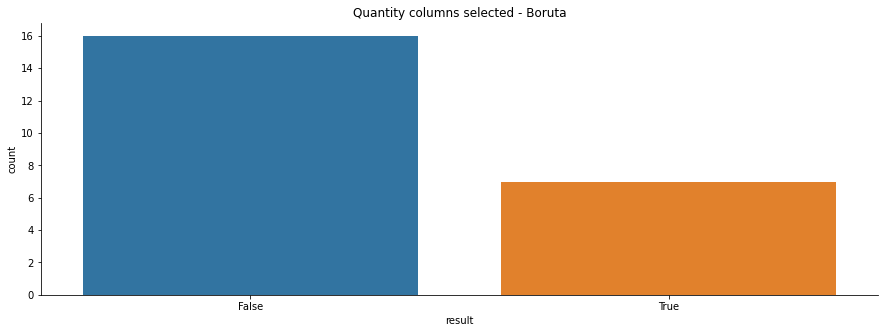

In [46]:
# Selected Boruta
result = boruta_trained.support_.tolist()

# Best Features
selected = x_train.iloc[:, result].columns.to_list()

# Not Selected Boruta
not_selected = list(np.setdiff1d(x_train.columns, selected))

# resume
resume = pd.DataFrame({'columns': x_train.columns, 'result': result})
reseume_selected = pd.DataFrame({'Selected': selected})

# plot
plt.figure(figsize=(15, 5))
sns.countplot(x='result', data=resume)
plt.title('Quantity columns selected - Boruta')
sns.despine(right=True)

reseume_selected

## 6.3 Filtragem de Variaveis

In [93]:
cols_selected_importance = ['age', 'credit_score', 'estimated_salary', 'num_of_products', 'customer_return',
                            'category_age', 'balance', 'tenure', 'is_active_member', 'credit_score_category',
                            'num_of_products_category', 'has_cr_card', 'gender']

cols_selected_boruta = ['age', 'balance', 'is_active_member', 'category_age', 'num_of_products_category', 'num_of_products']
cols_selected_final = list(set(cols_selected_importance + cols_selected_boruta))

x_train = x_train[cols_selected_final]
x_test = x_test[cols_selected_final]

# 7.0 MACHINE LEARNING

## 7.1 Naive Bayes

Precision_topk_50: 0.8235294117647058
Recall_topk_50: 0.10687022900763359


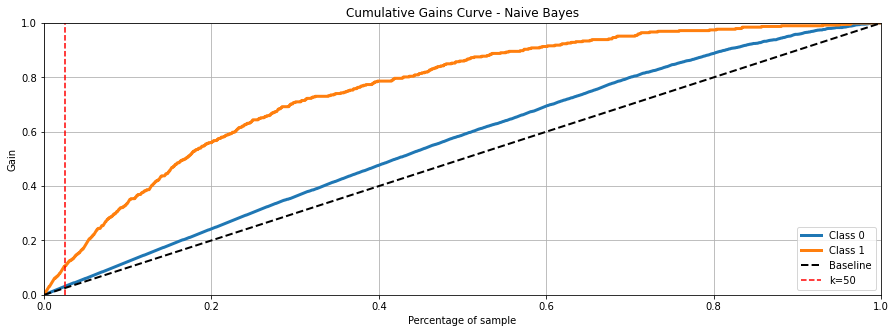

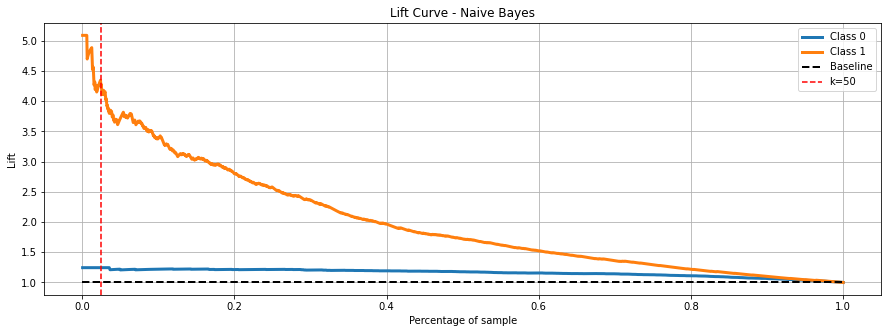

In [94]:
# define model
naive_bayes = GaussianNB()

# training and predict
bayes_trained = naive_bayes.fit(x_train, y_train)
yhat_bayes = bayes_trained.predict_proba(x_test)

# Add prob in the data to cumpute metric
x_test_bayes = x_test.copy()
x_test_bayes['response'] = y_test

# Propensity score
x_test_bayes['score'] = list(yhat_bayes[:, 1])

# Sort clients by propensity score
x_test_bayes = x_test_bayes.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_bayes, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_bayes, k=k))

# plot curve
plot_curve('Naive Bayes', y_pred=yhat_bayes, y_true=y_test)

**Insight:**

Precision to at k: de todas as predições de Churn dentro de k=100, 68% eram de fato Churn.

Recall top at k: de todas as predições de churn da base, 17% estão em k=100.

### 7.1.1 Cross Validation - Naive Bayes

In [95]:
# data to cross validation
x_full = pd.concat([x_train, x_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

bayes_cv = cross_validation(model_name='Naive Bayes CV', x=x_full, y=y_full, model=naive_bayes, cv=5, k=k, verbose=True)
bayes_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,Naive Bayes CV,50,0.811765,0.101618


## 7.2 Logistic Regression

Precision_topk_50: 0.8823529411764706
Recall_topk_50: 0.11450381679389313


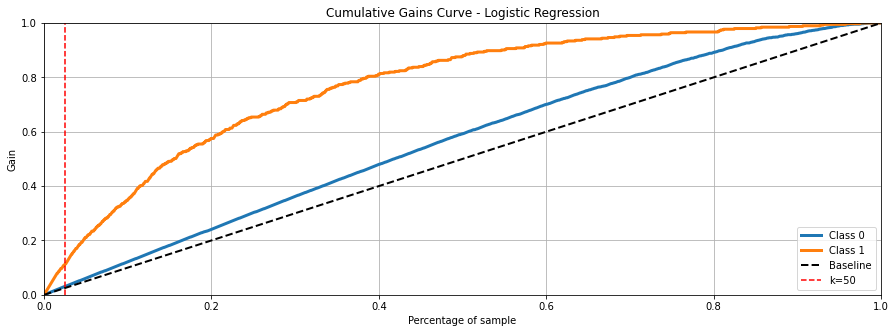

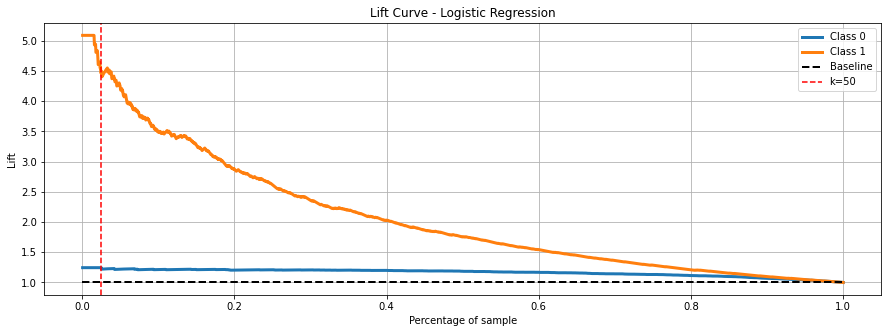

In [96]:
# define model
lr = LogisticRegression()

# training and predict
lr_trained = lr.fit(x_train, y_train)
yhat_lr = lr_trained.predict_proba(x_test)

# Add prob in the data to cumpute metric
x_test_lr = x_test.copy()
x_test_lr['response'] = y_test

# Propensity score
x_test_lr['score'] = list(yhat_lr[:, 1])

# Sort clients by propensity score
x_test_lr = x_test_lr.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_lr, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_lr, k=k))

# plot curve
plot_curve('Logistic Regression', y_pred=yhat_lr, y_true=y_test)

### 7.2.1 Logistic Regression - Cross Validation

In [97]:
lr_cv = cross_validation(model_name='Logistic Regression CV', x=x_full, y=y_full, model=lr, cv=5, k=k, verbose=True)
lr_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,Logistic Regression CV,50,0.921569,0.115366


## 7.3 KNN

Precision_topk_50: 0.8627450980392157
Recall_topk_50: 0.11195928753180662


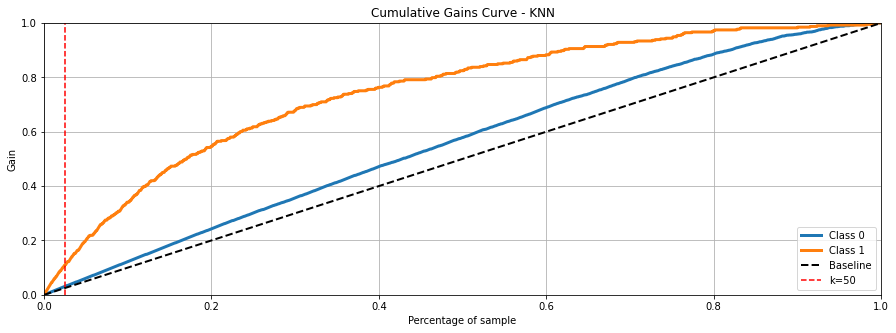

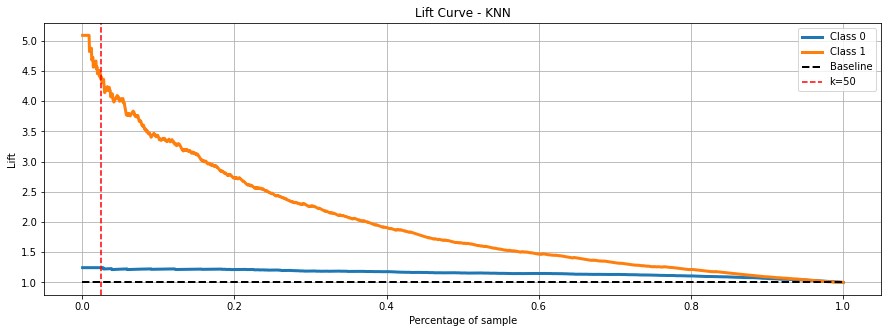

In [98]:
# define model
knn = KNeighborsClassifier(n_neighbors=20)

# training and predict
knn_trained = knn.fit(x_train, y_train)
yhat_knn = knn_trained.predict_proba(x_test)

# Add prob in the data to cumpute metric
x_test_knn = x_test.copy()
x_test_knn['response'] = y_test

# Propensity score
x_test_knn['score'] = list(yhat_knn[:, 1])

# Sort clients by propensity score
x_test_knn = x_test_knn.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_knn, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_knn, k=k))

# plot curve
plot_curve('KNN', y_pred=yhat_knn, y_true=y_test)

### 7.3.1 KNN - Cross Validation

In [100]:
knn_cv = cross_validation(model_name='KNN CV', x=x_full, y=y_full, model=knn, cv=5, k=k, verbose=True)
knn_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,KNN CV,50,0.843137,0.105544


## 7.4 Random Forest

Precision_topk_50: 0.9215686274509803
Recall_topk_50: 0.11959287531806616


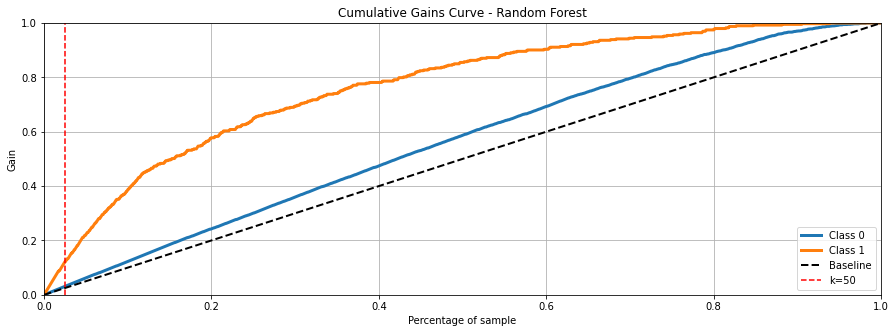

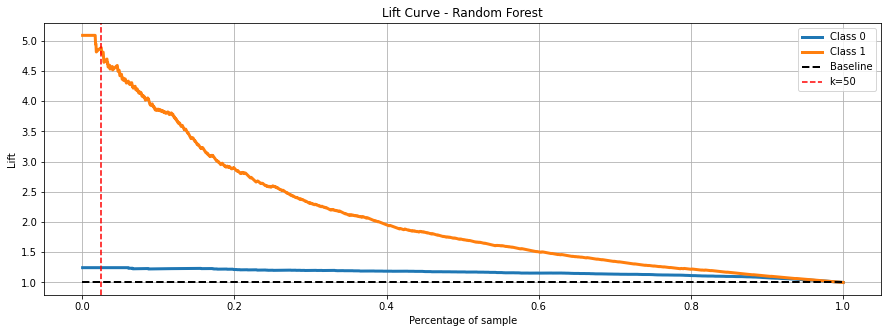

In [101]:
# define model
rf = RandomForestClassifier()

# training and predict
rf_trained = rf.fit(x_train, y_train)
yhat_rf = rf_trained.predict_proba(x_test)

# Add prob in the data to cumpute metric
x_test_rf = x_test.copy()
x_test_rf['response'] = y_test

# Propensity score
x_test_rf['score'] = list(yhat_rf[:, 1])

# Sort clients by propensity score
x_test_rf = x_test_rf.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_rf, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_rf, k=k))

# plot curve
plot_curve('Random Forest', y_pred=yhat_rf, y_true=y_test)

### 7.4.1 Random Forest - Cross Validation

In [102]:
rf_cv = cross_validation(model_name='Random Forest CV', x=x_full, y=y_full, model=rf, cv=5, k=k, verbose=True)
rf_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,Random Forest CV,50,0.933333,0.116836


## 7.5 XGBoost

Precision_topk_50: 0.9803921568627451
Recall_topk_50: 0.1272264631043257


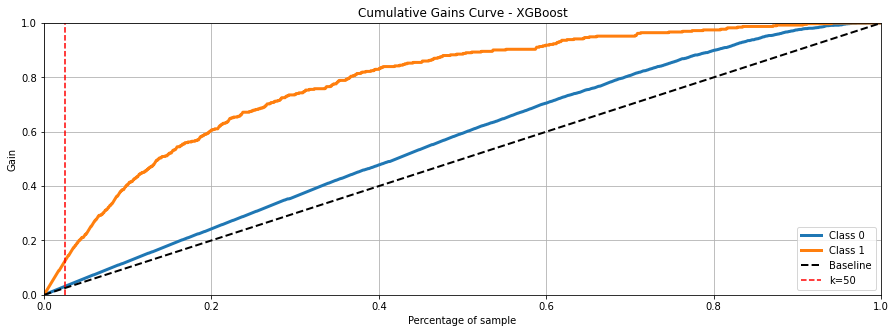

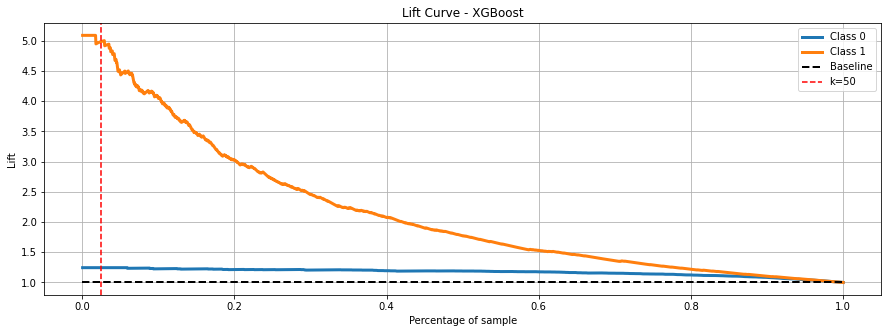

In [103]:
# define model
xgboost = xgb.XGBClassifier()

# training and predict
xgboost_trained = xgboost.fit(x_train, y_train)
yhat_xgboost = xgboost_trained.predict_proba(x_test)

# Add prob in the data to cumpute metric
x_test_xgboost = x_test.copy()
x_test_xgboost['response'] = y_test

# Propensity score
x_test_xgboost['score'] = list(yhat_xgboost[:, 1])

# Sort clients by propensity score
x_test_xgboost = x_test_xgboost.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_xgboost, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_xgboost, k=k))

# plot curve
plot_curve('XGBoost', y_pred=yhat_xgboost, y_true=y_test)

### 7.5.1 XGBoost - Cross Validation

In [104]:
xgboost_cv = cross_validation(model_name='XGBoost CV', x=x_full, y=y_full, model=xgboost, cv=5, k=k, verbose=True)
xgboost_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,XGBoost CV,50,0.968627,0.121258


## 7.6 LGBM

Precision_topk_50: 0.9607843137254902
Recall_topk_50: 0.12468193384223919


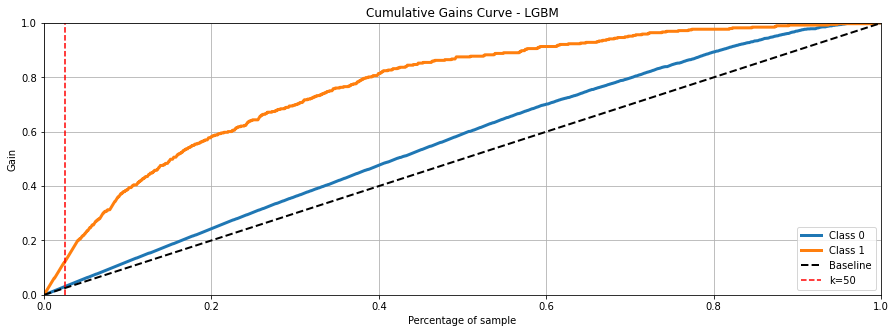

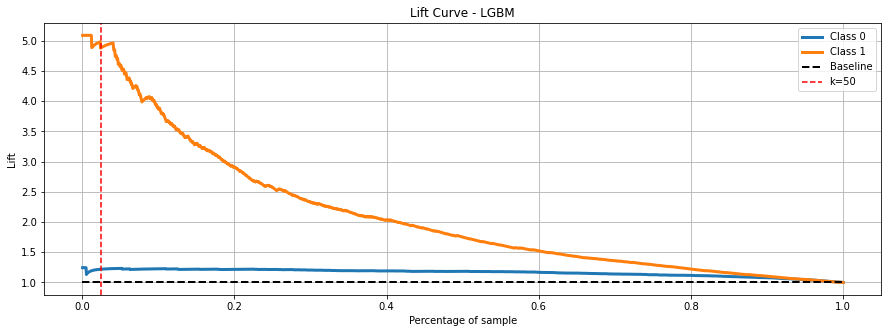

In [105]:
# define model
lgbm = LGBMClassifier()

# training and predict
lgbm_trained = lgbm.fit(x_train, y_train)
yhat_lgbm = lgbm_trained.predict_proba(x_test)

# Add prob in the data to cumpute metric
x_test_lgbm = x_test.copy()
x_test_lgbm['response'] = y_test

# Propensity score
x_test_lgbm['score'] = list(yhat_lgbm[:, 1])

# Sort clients by propensity score
x_test_lgbm = x_test_lgbm.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_lgbm, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_lgbm, k=k))

# plot curve
plot_curve('LGBM', y_pred=yhat_lgbm, y_true=y_test)

### 7.6.1 LGBM - Cross Validation

In [106]:
lgbm_cv = cross_validation(model_name='LGBM CV', x=x_full, y=y_full, model=lgbm, cv=5, k=k, verbose=True)
lgbm_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,LGBM CV,50,0.964706,0.120766


## 7.7 Combinação de Modelos

Precision_topk_50: 0.9803921568627451
Recall_topk_50: 0.1272264631043257


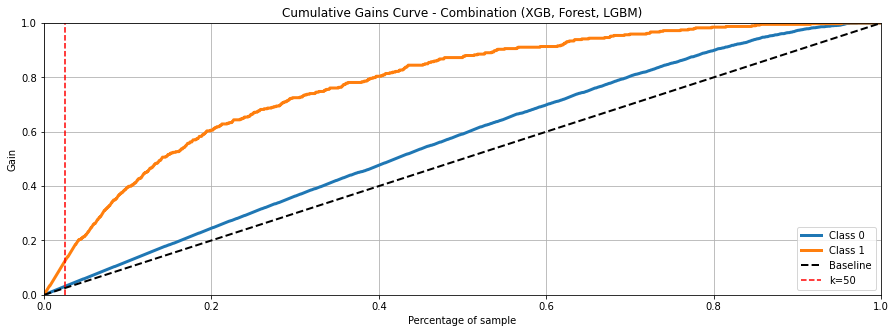

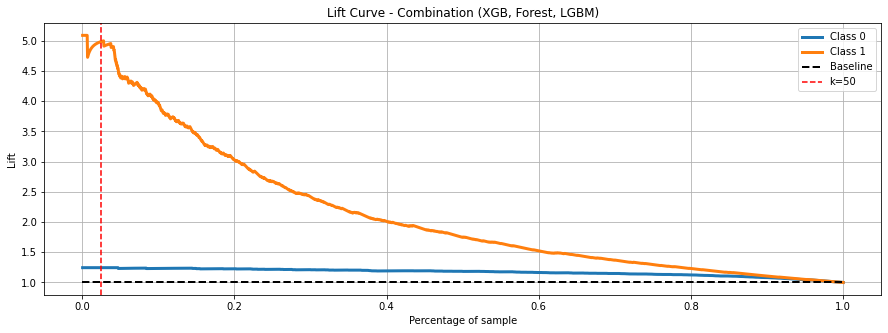

In [107]:
xgboost = xgb.XGBClassifier()
rf = RandomForestClassifier()
lgbm = LGBMClassifier()

models = [('xgb', xgboost), ('forest', rf), ('lgbm', lgbm)]
models_combined = VotingClassifier(models, voting='soft')

models_combined_trained = models_combined.fit(x_train, y_train)
yhat_models_combined = models_combined_trained.predict_proba(x_test)


# Add prob in the data to cumpute metric
x_test_ensemble = x_test.copy()
x_test_ensemble['response'] = y_test

# Propensity score
x_test_ensemble['score'] = list(yhat_models_combined[:, 1])

# Sort clients by propensity score
x_test_ensemble = x_test_ensemble.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_ensemble, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_ensemble, k=k))

# plot curve
plot_curve('Combination (XGB, Forest, LGBM)', y_pred=yhat_models_combined, y_true=y_test)

### Combinação de Modelos - Cross Validation

In [108]:
models_combined_cv = cross_validation(model_name='Combination (XGB, Forest, LGBM) CV', x=x_full, y=y_full, model=models_combined, cv=5, k=k, verbose=True)
models_combined_cv

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,model_name,number of K,precision_top_at,recall_top_at
0,"Combination (XGB, Forest, LGBM) CV",50,0.968627,0.121257


## 7.8 Comparação Performance

In [109]:
performance_cv = pd.concat([bayes_cv, lr_cv, knn_cv, rf_cv, xgboost_cv, lgbm_cv, models_combined_cv], axis=0)
performance_cv.sort_values(by='recall_top_at', ascending=False)

,model_name,number of K,precision_top_at,recall_top_at
0,XGBoost CV,50,0.968627,0.121258
0,"Combination (XGB, Forest, LGBM) CV",50,0.968627,0.121257
0,LGBM CV,50,0.964706,0.120766
0,Random Forest CV,50,0.933333,0.116836
0,Logistic Regression CV,50,0.921569,0.115366
0,KNN CV,50,0.843137,0.105544
0,Naive Bayes CV,50,0.811765,0.101618


# 8.0 AJUSTE DE HIPERPARAMETROS

## 8.1 Grid Search

In [63]:
parameters_xgb = {
    'min_child_weight': [3, 8, 15],
    'n_estimators': [500, 1000, 1500], 
    'max_depth': [5, 7, 9]
}

parameters_rf = {
    'min_child_weight': [3, 8, 15],
    'n_estimators': [500, 1000, 1500], 
    'max_depth': [5, 7, 9]
}

parameters_lgbm = {
    'min_child_weight': [3, 8, 15],
    'n_estimators': [500, 1000, 1500], 
    'max_depth': [5, 7, 9]
}


search_xgb = grid_search(
            min_child_weight=parameters_xgb['min_child_weight'],
            n_estimators=parameters_xgb['min_child_weight'],
            max_depth=parameters_xgb['max_depth'], 
            model_name='XGB Search', model='xgboost'
        )
print('GRID SEARCH - XGBOOST')
print(search_xgb, '\n')

search_rf = grid_search(
            min_child_weight=parameters_rf['min_child_weight'],
            n_estimators=parameters_rf['min_child_weight'],
            max_depth=parameters_rf['max_depth'], 
            model_name='RF Search', model='forest'
        )
print('GRID SEARCH - RANDOM FOREST', '\n')
print(search_rf)

search_lgbm = grid_search(
            min_child_weight=parameters_lgbm['min_child_weight'],
            n_estimators=parameters_lgbm['min_child_weight'],
            max_depth=parameters_lgbm['max_depth'], 
            model_name='LGBM Search', model='lgbm'
        )
print('GRID SEARCH - LGBM', '\n')
print(search_lgbm)

GRID SEARCH - XGBOOST
   model_name  number of K  precision_top_at  recall_top_at  min_child_weight  \
0  XGB Search          200          0.791045       0.390274                 3   
0  XGB Search          200          0.790050       0.389788                 3   
0  XGB Search          200          0.790050       0.389785                 3   
0  XGB Search          200          0.789055       0.389293                 8   
0  XGB Search          200          0.788060       0.388803                 8   

   n_estimators  max_depth  cross_validation  
0            15          5                 5  
0            15          9                 5  
0            15          7                 5  
0             8          5                 5  
0             3          5                 5   

GRID SEARCH - RANDOM FOREST 

  model_name  number of K  precision_top_at  recall_top_at  min_child_weight  \
0  RF Search          200          0.797015       0.393213                15   
0  RF Search     

## 8.2 Modelo Final

### 8.2.1 Treinamento

In [136]:
xgboost = xgb.XGBClassifier(min_child_weight=8, n_estimators=15, max_depth=7)
rf = RandomForestClassifier(min_samples_split=3, n_estimators=15, max_depth=5)
lgbm = LGBMClassifier(min_child_weight=3, n_estimators=15, max_depth=5)

models = [('xgb', xgboost), ('forest', rf), ('lgbm', lgbm)]
model_final = VotingClassifier(models, voting='soft')

model_final_trained = model_final.fit(x_train, y_train)

### 8.2.2 Teste

Precision_topk_50: 0.9607843137254902
Recall_topk_50: 0.12468193384223919


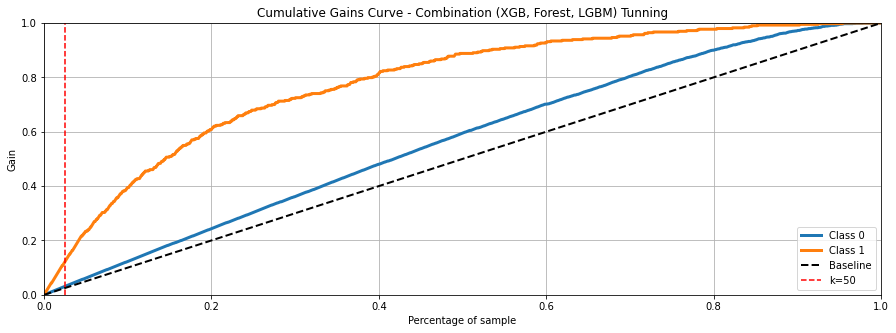

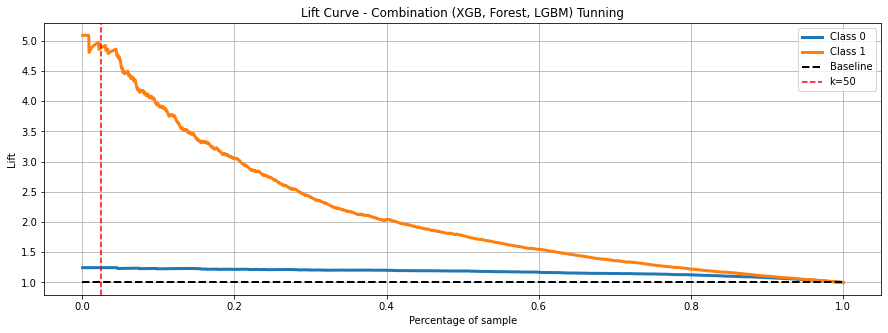

In [137]:
yhat_model_final = model_final_trained.predict_proba(x_test)

# Add prob in the data to cumpute metric
x_test_model_final = x_test.copy()
x_test_model_final['response'] = y_test

# Propensity score
x_test_model_final['score'] = list(yhat_model_final[:, 1])

# Sort clients by propensity score
x_test_model_final = x_test_model_final.sort_values(by='score', ascending=False)

# Compute precision at K
k = 50
porcentage_k = k / len(x_test)
print(f'Precision_topk_{k}:', precision_at_k(x_test_model_final, k=k))
print(f'Recall_topk_{k}:', recall_at_k(x_test_model_final, k=k))

# plot curve
plot_curve('Combination (XGB, Forest, LGBM) Tunning', y_pred=yhat_model_final, y_true=y_test)

# 9.0 TRADUÇÃO E INTERPRETAÇÃO

Lembrando que, o banco ganha dinheiro assim:

Se o salario do cliente for maior que o salario médio do banco, a empresa fica com 20% do salario.

Se o salario do clientes dor menor que o salario médio do banco, a empresa fica com 15% do salario.

## 9.1 Cupom de desconto

In [127]:
# CLIENTES QUE RECEBRAO O CUPOM DE DESCONTO:
churn = x_test_model_final.iloc[:k, :].copy()

# reverse transformation in salary
churn['estimated_salary'] = mms_salary.inverse_transform(churn[['estimated_salary']].values)

# salario medio banco
salary_bank = churn['estimated_salary'].mean()

# verify conditions
churn['lucro_bruto'] = churn['estimated_salary'].apply(lambda x: (x * 20) / 100 if x > salary_bank else (x * 15) / 100)

churn['discount_customer'] = (churn['lucro_bruto'] * 5) / 100
churn['lucro_liquido'] = (churn['lucro_bruto'] - churn['discount_customer'])

metrics_business = churn[['estimated_salary', 'score', 'discount_customer', 'lucro_bruto', 'lucro_liquido']].copy()
print('Budget de desconto aos clientes (Total): {:.2f}'.format(metrics_business['discount_customer'].sum()))
print('Cumpom de desconto: 5%')
print('Lucro Antes dos gastos:', np.round(metrics_business['lucro_bruto'].sum(), 2))
print('Lucro após os gastos:', np.round(metrics_business['lucro_liquido'].sum(), 2))

Budget de desconto aos clientes (Total): 45041.07
Cumpom de desconto: 5%
Lucro Antes dos gastos: 900821.46
Lucro após os gastos: 855780.38


### 1. Qual a taxa atual de Churn da TopBank?


In [129]:
# actual churn
n_exited = len(df1[df1['exited'] == 1])
n_customers = len(df1)
tax_churn = (n_exited / n_customers) * 100

# new churn
precision_churn = np.round(precision_at_k(x_test_model_final, k=k), 2)
received_discount = int(precision_churn * k)

n_churn_bank = len(df1[df1['exited'] == 1])
n_new_churn_bank = n_churn_bank - received_discount
new_tax_churn = (n_new_churn_bank / n_customers) * 100

print('Taxa de Churn atual é de: {:.2f}%'.format(tax_churn))
print('Nova taxa de Churn do banco é de:', str(new_tax_churn) + '%')

Taxa de Churn atual é de: 20.37%
Nova taxa de Churn do banco é de: 19.88%


### 2. Qual a Performance do modelo em classificar os clientes como churns?


Em uma base de 2 mil clientes, ranqueando-a para 50 clientes a performance do modelo é de: 96%. Ou seja, dentro dos 50 clientes, **96% (48)** são de fato Churn. 

### 3. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

,Lucro Total,Gasto cupom
0,855780.38,45041.073


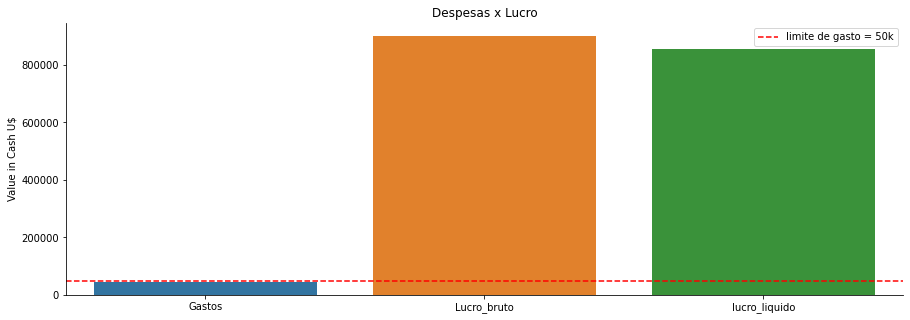

In [138]:
plt.figure(figsize=(15, 5))
sns.barplot(x=['Gastos', 'Lucro_bruto', 'lucro_liquido'],
            y=[metrics_business['discount_customer'].sum(),
               metrics_business['lucro_bruto'].sum(),
               metrics_business['lucro_liquido'].sum()])
sns.despine(right=True)
plt.ylabel('Value in Cash U$')
plt.title('Despesas x Lucro')
plt.axhline(50000, color='r', linestyle='dashed', label='limite de gasto = 50k')
plt.legend();

pd.DataFrame({'Lucro Total': np.round(metrics_business['lucro_liquido'].sum(), 2), 'Gasto cupom': np.round(metrics_business['discount_customer'].sum(), 3)}, index=[0])

# 10.0 DEPLOY

## 10.1 Salvar Modelo

In [139]:
pickle.dump(model_final_trained, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/model/model.pkl', 'wb'))

## 10.2 Salvar Transformações

In [140]:
# Min Max Scaler
pickle.dump(mms_balance_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/mms_balance.pkl', 'wb'))
pickle.dump(mms_salary_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/mms_salary.pkl', 'wb'))

# Robust Scaler
pickle.dump(rs_age_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/rs_age.pkl', 'wb'))
pickle.dump(rs_customer_return_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/rs_customer_return.pkl', 'wb'))

# Standard Scaler
pickle.dump(sc_credit_score_test, open('C:/Users/Jhonatans/projects/ML/Classification/Bank-Customer-Churn/src/preparation/sc_credit_score.pkl', 'wb'))

## 10.3 Teste API

### Dicionario de Dados:

RowNumber: O número da coluna

CustomerID: Identificador único do cliente

Surname: Sobrenome do cliente.

CreditScore: A pontuação de Crédito do cliente para o mercado de consumo.

Geography: O país onde o cliente reside.

Gender: O gênero do cliente.

Age: A idade do cliente.

Tenure: Número de anos que o cliente permaneceu ativo.

Balance: Valor monetário que o cliente tem em sua conta bancária.

NumOfProducts: O número de produtos comprado pelo cliente no banco.

HasCrCard: Indica se o cliente possui ou não cartão de crédito.

IsActiveMember: Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.

EstimateSalary: Estimativa do salário mensal do cliente.

Exited: Indica se o cliente está ou não em Churn.